In [208]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [209]:
def cal_precision(pred,true_label):
    """
    Args:
        pred : tensor, shape [N]
        true_label : tensor true label shape [N]
    return :
        precision
    """
    # assume pred.shape == true_label.shape
    res = (pred == true_label)
    count = np.mean(res)
    return count

def cal_recall(pred,true_label):
    """
    Args:
        pred : tensor, shape [N]
        true_label : tensor true label shape [N]
    return :
        recall
    """
    res = (pred == true_label)*pred
    recall = np.sum(res)/np.sum(true_label)
    return recall

def mean_seq(seq,k=120):
    result = []
    length = len(seq)//k
    for i in range(length-1):
        result.append(1.0*sum(seq[i*k:(i+1)*k])/k)
    return result

In [210]:
valid_info = pd.read_csv("../model/valid_Hammers_lr1.e-3_dp0.6_fold3_info.csv")
train_info = pd.read_csv("../model/train_Hammers_lr1.e-3_dp0.6_fold3_info.csv")
info = {
    "label0_precision":[],"label1_precision":[],"label2_precision":[],
    "label0_recall":[],"label1_recall":[],"label2_recall":[],
    "label0_f1":[],"label1_f1":[],"label2_f1":[],"macro_f1":[],
    "mean_f1":[]
}
for epoch in range(0,1000):
    if "epoch%d_true_label"%(epoch) not in valid_info.columns:
        continue
    true_label = valid_info["epoch%d_true_label"%(epoch)].to_numpy()
    scores = valid_info[["epoch%d_label%d_scores"%(epoch,0),
        "epoch%d_label%d_scores"%(epoch,1),
        "epoch%d_label%d_scores"%(epoch,2)]].to_numpy()
    max_scores = np.expand_dims(np.max(scores,axis=1),axis=1)
    scores = (scores > max_scores*0.99999)
    for i in range(3):
        label_precision = cal_precision(scores[:,i],true_label==i)
        label_recall = cal_recall(scores[:,i],true_label==i)
        f1 = 2*label_precision*label_recall/(label_precision+label_recall)
        info["label%d_precision"%(i)].append(label_precision)
        info["label%d_recall"%(i)].append(label_recall)
        info["label%d_f1"%(i)].append(f1)
    mean_p = np.mean([info["label%d_precision"%(i)][-1] for i in range(3)])
    mean_r = np.mean([info["label%d_recall"%(i)][-1] for i in range(3)])
    mean_f1 = np.mean([info["label%d_f1"%(i)][-1] for i in range(3)])
    info["macro_f1"].append(2 * mean_p * mean_r / (mean_p + mean_r))
    info["mean_f1"].append(mean_f1)
# find max macro f1
max_index,max_f1 = 0,0
for index,f1 in enumerate(info["macro_f1"]):
    if f1 > max_f1:
        max_f1 = f1
        max_index = index
print("Max F1 %.3f , Index %d"%(max_f1,max_index))
step_per_epoch = len(train_info)//(len(valid_info.columns)//4)
train_loss = np.mean(train_info["train_loss"].to_numpy()[step_per_epoch*max_index:step_per_epoch*(max_index+1)])
valid_loss = np.mean(train_info["valid_loss"].to_numpy()[step_per_epoch*max_index:step_per_epoch*(max_index+1)])
print("Train loss : %.3f , Valid loss : %.3f"%(train_loss,valid_loss))

Max F1 0.691 , Index 922
Train loss : 0.941 , Valid loss : 0.948


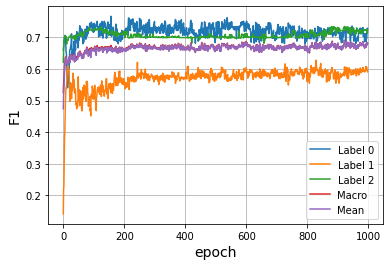

In [211]:
for i in range(3):
    plt.plot(info["label%d_f1"%(i)],label="Label %d"%(i))
plt.plot(info["macro_f1"],label="Macro")
plt.plot(info["mean_f1"],label="Mean")
plt.xlabel("epoch",fontsize=14)
plt.ylabel("F1",fontsize=14)
plt.grid(True)
plt.legend()

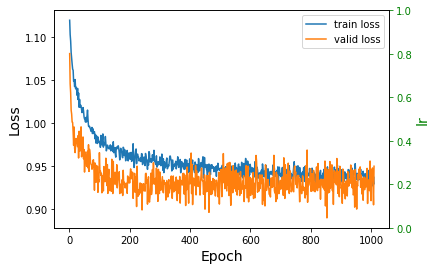

In [212]:
# draw the loss and lr
data = train_info
loss_fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(mean_seq(data["epoch"]),mean_seq(data["train_loss"].to_numpy()),label="train loss")
ax1.plot(mean_seq(data["epoch"]),mean_seq(data["valid_loss"].to_numpy()),label="valid loss")
ax1.legend()
ax1.set_xlabel('Epoch',fontsize=14)
ax1.set_ylabel('Loss',fontsize=14)
ax2.set_ylabel('lr', color='g',fontsize=14)
ax2.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
ax2.tick_params(colors="green")

       dim           f              p
0    14200  515.837841  2.284801e-189
1    13962  515.837841  2.284801e-189
2    14082  515.837841  2.284801e-189
3    15424  497.439576  1.278138e-183
4    14678  496.311468  2.890141e-183
..     ...         ...            ...
813  14687  200.262674   1.303909e-81
814   1771  200.254548   1.313121e-81
815   2046  200.124531   1.469697e-81
816  12384  200.076809   1.531744e-81
817   3231  200.067927   1.543578e-81

[818 rows x 3 columns]


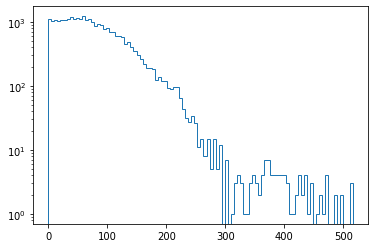

In [213]:
anova_info = pd.read_csv("../data/anova_info.csv")
plt.hist(anova_info["f"],histtype="step",bins=100)
plt.yscale("log")
print(anova_info[anova_info["f"] > 200])